## 1. Project Description
### 1.1 Project Objectives
This project has two main objectives:
1. Build an RNN model that predicts (classifies) whether a customer review about restaurants are positive or negative.
2. Build an unsupervised machine model that extracts key topics/themes from reviews.

<br>

### 1.2 Project Background
In order for a business to stay competitive, it needs to understand its customer feedbacks. What are customers saying about us? Are they happy with our products and services? Where do we need to improve upon? 

One important source of customer feedback is the reviews posted on specialized customer review platforms such as Google Reviews and Tripadvisor reviews. These review sites allow customers to post text reviews as well as a rating (usually 1-5 stars). Companies can take these reviews, segment them based on the rating or simply into postive and negative reviews. Companies can then analyze the negative reviews to understand their shortcomings and focus on the positive reviews to further enhance their competitive position.

However, with the advent of smart devices, more and more people are turning to social media to post their experiences with a brand. These social media posts are highly important (due to word of mouth), but much harder for the companies to efficiently analyze, because:
- there are no ratings (1-5)
- have to manually go through each post and sort them into positive/negative reviews, which is very resource intensive for companies

It would therefore be highly valuable, to train an automatic reviews classifier based on reviews that have a rating (e.g. data from specialized reviews platforms, such as Tripadvisor), and use the classifier to predict whether a social media post about a company (such as a Tweet) is positive or negative. In addition, it would be even more valuable to develop a model that can automatically extract keywords/themes from the reviews, as this will give human analysts even more efficient ways to understand and analyze the data.

<br>

### 1.3 Project Evaluation
Part 1 Classification:

Reviews data tend to have imbalanced data distributions:
- either many negative reviews and complaints vs. positive reviews, or
- an overwhelming proportion of positive reviews/high ratings vs. negative reviews

Therefore, accuracy will not be a suitable evaluation metric, as a naive strategy of always predicting the majority class will give us a (misleadingly) high accuracy.

The classification model results will be evaluated using the F1 score. The F1 score is the harmonic mean of precision and recall and it is calculated as:

$$F1 = 2 * \frac{precision\, * \,recall}{precision\, + \,recall}$$

Where

$$precision = \frac{True \, Positives}{True\, Positives \, + \, False \,Positives}$$

$$recall = \frac{True \,Positives}{True\, Positives \, + \, False \,Negatives}$$

Unlike accuracy, the F1 score does not suffer from class imbalance problems, however it is less interpretable than accuracy.

Part 2 Topic Modelling:

Unlike supervised methods, unsupervised methods don't have a "ground truth" to evaluate against. There are mathematical methods such as various distance metrics that can be use for evaluating topic models, but in this project, we feel that it is more important to apply human logic and judgement. Therefore the topic model will be evaluated on whether it provides meaningful and interpretable results.

-------------

## 2. Data Description
### 2.1 Data Understanding
The dataset for this project contains English reviews for restaurants on Tripadvisor. The full dataset contains 6 CSVs, one for each of the following cities: Barcelona, London, Madrid, New Delhi, New York and Pairs. Our project will focus the Barcelona data. 

The Barcelona data contains:
- more than 416k observations (reviews)
- 12 columns/features

Feature definition:
1. parse_count: numerical (integer), corresponding number of extracted review by the web scraper (auto-incremental, starts from 1)
2. author_id: categorical (string), univocal, incremental and anonymous identifier of the user (UID_XXXXXXXXXX)
3. restaurant_name: categorical (string), name of the restaurant matching the review
4. rating_review: numerical (integer), review score in the range 1-5
5. sample: categorical (string), indicating “positive” sample for scores [4-5] and “negative” for scores [1-3]
6. review_id: categorical (string), univocal and internal identifier of the review (review_XXXXXXXXX)
7. title_review: text, review title
8. review_preview: text, preview of the review, truncated in the website when the text is very long
9. review_full: text, complete review
10. date: timestamp, publication date of the review in the format (day, month, year)
11. city: categorical (string), city of the restaurant which the review was written for
12. url_restaurant: text, restaurant url

### 2.2 Data Source and Acknowledgements
The dataset used for this project was found on [Kaggle](https://www.kaggle.com/datasets/inigolopezrioboo/a-tripadvisor-dataset-for-nlp-tasks?select=Barcelona_reviews.csv).

If you use these data, please cite the datasets using the associated [Zenodo DOI](https://doi.org/10.5281/zenodo.6583422) as I am doing here.

If you use these data, please cite the [related paper](https://arxiv.org/abs/2205.01759).

> Botana, Iñigo López-Riobóo, Verónica Bolón-Canedo, Bertha Guijarro-Berdiñas, and Amparo Alonso-Betanzos. "Explain and Conquer: Personalised Text-based Reviews to Achieve Transparency." arXiv preprint arXiv:2205.01759 (2022).

Please notice that these datasets are under a CC-BY-NC 4.0 International license. You must NOT use the material for commercial purposes.


-----------

## 3. Importing the Libraries and Data
### 3.1 Importing the Libraries

In [1]:
# 3.1.1 Importing the common libraries
import pandas as pd
import numpy as np
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [2]:
# 3.1.2 Natural Language libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from keras_preprocessing.text import text_to_word_sequence
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# 3.1.3 Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [4]:
# 3.1.4 Deep Learning libraries
import tensorflow as tf
import keras # high-level deep learning API
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Embedding,LSTM,
                          Dense,
                          SpatialDropout1D,
                          Bidirectional,
                          BatchNormalization,
                          TimeDistributed, 
                          Dropout, 
                          Flatten, 
                          GlobalMaxPool1D)
from keras.initializers import Constant
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K

### 3.2 Importing the Data

In [5]:
fulldata = pd.read_csv(r'../input/a-tripadvisor-dataset-for-nlp-tasks/Barcelona_reviews.csv')
fulldata.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,0,1,Chalito_Rambla,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...","October 12, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,1,2,Chalito_Rambla,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,"January 14, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,2,3,Chalito_Rambla,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,"March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
3,3,4,Chalito_Rambla,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p...","The food is execellent ,affortable price for p...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_3
4,4,5,Chalito_Rambla,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso...","Mr Suarez,The food at your restaurant was abso...","March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_4


### 3.2.1 Initial Data Understanding
When we get a dataset it can often be helpful to just run a quick check on the data's key statistics and information. We can understand whether the data has decent quality (values of expected types and in reasonable numerical ranges), and also drop features that are clearly irrelevant to help us save memory (especially on a large dataset).

In [6]:
fulldata.describe(include = 'all')

,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
count,416356,416356,416356,416356,416356,416356,416355,416355,416354,416354,416354,416354,416354
unique,416356,416356,6622,11,3,416356,286450,416152,416185,4496,5,45571,232020
top,0,1,Cerveceria_Catalana,5,Positive,review_774086112,Excellent,"Great tapas, a variety of tastes, all tasted e...","Great tapas, a variety of tastes, all tasted e...","October 18, 2016",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_7046
freq,1,1,5628,203206,338779,1,1495,4,4,413,416325,10,390


In [7]:
fulldata.info()
# memory usage of 41.3+ MB and all features are of "object" type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416356 entries, 0 to 416355
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       416356 non-null  object
 1   parse_count      416356 non-null  object
 2   restaurant_name  416356 non-null  object
 3   rating_review    416356 non-null  object
 4   sample           416356 non-null  object
 5   review_id        416356 non-null  object
 6   title_review     416355 non-null  object
 7   review_preview   416355 non-null  object
 8   review_full      416354 non-null  object
 9   date             416354 non-null  object
 10  city             416354 non-null  object
 11  url_restaurant   416354 non-null  object
 12  author_id        416354 non-null  object
dtypes: object(13)
memory usage: 41.3+ MB


We can see based on the previews of the dataset that:
- Unnamed:0, parse_count are irrelevant information, as we already have review_id as the unique id, 
- restaurant_name is not a feature that we are interested in, 
- review_preview and review_full are redundant, and we will only keep review_full,
- date, city and url_restaurant are not features that we are interested in.

We can drop the above mentioned features.

In [6]:
trimdata = fulldata.copy()
trimdata.drop(trimdata.columns[[0,1,2,7,9,10,11,12]], axis = 1, inplace = True) # column index can be read from df.info()
trimdata.head()

,rating_review,sample,review_id,title_review,review_full
0,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve..."
1,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...
2,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...
3,5,Positive,review_749732001,Best food,"The food is execellent ,affortable price for p..."
4,5,Positive,review_749691057,Amazing Food and Fantastic Service,"Mr Suarez,The food at your restaurant was abso..."


In [16]:
trimdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416356 entries, 0 to 416355
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   rating_review  416356 non-null  object
 1   sample         416356 non-null  object
 2   review_id      416356 non-null  object
 3   title_review   416355 non-null  object
 4   review_full    416354 non-null  object
dtypes: object(5)
memory usage: 15.9+ MB


As we can see, by trimming the unnecessary features off our dataset, we are able to cut down our memory usage from 41MB to just 16MB.

### 3.2.2 Splitting Data to Prevent Data Leakage
It is important to split our data into training and test sets before we perform any analysis to prevent data leakage

In [7]:
# Let's first perform some essential cleaning steps so that our dataframe and feature names make more sense
# 1) swap column orders so that review_id is in front
trimdata = trimdata[['review_id', 'rating_review','sample','title_review','review_full']]

# 2) combine title_review and review_full into a single feature, and rename the feature as just 'review'
# drop the redundant features
trimdata['review'] = trimdata['title_review'] + " " + trimdata['review_full']
trimdata.drop(['title_review','review_full'], axis = 1, inplace = True)

# 3) rename the columns so that they make more sense
trimdata.columns = ['review_id', 'rating', 'sentiment', 'review' ]

In [18]:
trimdata.head()
# looking good

,review_id,rating,sentiment,review
0,review_774086112,1,Negative,"Terrible food Terrible service Ok, this place ..."
1,review_739142140,5,Positive,The best milanesa in central Barcelona This pl...
2,review_749758638,5,Positive,Family bonding The food is excellent.....the a...
3,review_749732001,5,Positive,"Best food The food is execellent ,affortable p..."
4,review_749691057,5,Positive,"Amazing Food and Fantastic Service Mr Suarez,..."


In [8]:
trimdata.dropna(inplace = True) # Note there is one row of 'missing value' as the result of web scraping, so we can safely drop it

In [9]:
X = trimdata.drop('sentiment', axis = 1) # I have a strong feeling that reviews rating is highly imbalanced
y = trimdata.sentiment # So we will set our target to sentiment for now and verify this through EDA in the next section

X_trainval, X_test, y_trainval, y_test = train_test_split(X, 
                                                          y,
                                                          test_size = 0.1, # since data is relatively large, a smaller proportion of test size will do
                                                          stratify = y,
                                                          random_state = 42)

print(f'Size of training and validation sets are X: {X_trainval.shape}, y:{y_trainval.shape}')
print(f'Size of test set is X: {X_test.shape}, y:{y_test.shape}')

Size of training and validation sets are X: (374718, 3), y:(374718,)
Size of test set is X: (41636, 3), y:(41636,)


In [25]:
X_trainval.head()

,review_id,rating,review
150327,review_646954484,5,The best sushi in Barcelona! What a treat! Fre...
43614,review_735484397,5,Fantastic !! Food at this place is simply awes...
113861,review_163709852,4,Worth the wait! Everyone that has been to Bo d...
331406,review_127320404,5,Come and eat here! The hot and sour soup was t...
143261,review_150510792,5,Amazing LLamber Finally an amazing & high qual...


In [26]:
y_trainval.head()

150327    Positive
43614     Positive
113861    Positive
331406    Positive
143261    Positive
Name: sentiment, dtype: object

-----------------

## 4. Exploratory Data Analysis (EDA)
EDA serves two main purposes:

1. Verifying data quality: guides us in data cleaning and preparation
* Missing values
* Duplicate entries
* Inconsistent entries and labels
* Outliers
* Rare categorical classes
* etc...
2. Exploring data characteristics: guides us in feature engineering
* Patterns unique/interesting in the data
* Feature characteristics and distribution
* etc...

### 4.1 Data Quality Exploration
#### 4.1.1 Missing Values
As expected, we have no missing values right now.

<AxesSubplot:>

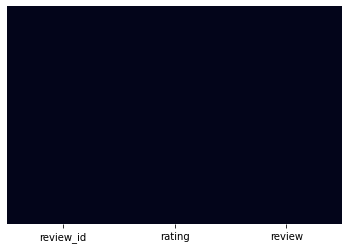

In [27]:
sns.heatmap(X_trainval.isnull(), annot = False, cbar = False, yticklabels = False)

#### 4.1.2 Duplicate entries
We are particularly interested in "review" that are duplicated.

In [29]:
X_trainval.review.duplicated().sum()

54

In [31]:
X_trainval[X_trainval.review.duplicated()]

,review_id,rating,review
259147,review_326210272,5,Gorgeous Spectacular interiors & ambiance in b...
401341,review_587098850,5,מסעדה מעולה We at the restaurant following the...
308220,review_238144445,5,one of the best chinese meals Tired of tapas. ...
400438,review_361748442,5,Best tapas bar :) I went there basicly everyda...
222384,review_436836159,5,"Baby calamar Delicious sea foods,tapas and Med..."
339126,review_168784354,2,"Surly waiters. Non-attentive waitstaff, with d..."
341018,review_510896108,1,Unreliable... In the past 6 months our working...
268209,review_163005960,4,Worth a stop. We stopped here for a snack/drin...
259621,review_343965454,5,"Bueaitful surroundings, great food Visited whi..."
284914,review_428419497,4,Worth a visit I can see very missed reviews so...


Although df.duplicated() is suggesting that we have duplicate data, but on closer inspection, the reviews are not actually identical, so we will proceed using the current data.

### 4.1.3 Inconsistent Entries or Labels

In [32]:
X_trainval.rating.unique()

array(['5', 5, 4, '2', 3, 2, '4', '1', 1, '3'], dtype=object)

In [10]:
X_trainval.rating.value_counts()

5    182963
4     72323
5     34847
3     25378
1     21059
4     14767
2     14017
3      4453
1      2584
2      2327
Name: rating, dtype: int64

We can see that some ratings are numerical while others are strings in terms of data format, this is clearly problematic, and requires cleaning.

In [11]:
y_trainval.unique()

array(['Positive', 'Negative'], dtype=object)

The target labels are consistent, and free from spelling variations, which is good. Often times though, we tend to see inconsistent labelling (especially in casing), e.g. Positive vs. positive, in those cases, we need to clean up the data.

### 4.2 Data Characteristic Exploration

In [12]:
# Let's first combine X trainval and y trainval for easier manipulation
edadata = pd.concat([X_trainval, y_trainval], axis = 1)
edadata.head()

,review_id,rating,review,sentiment
150327,review_646954484,5,The best sushi in Barcelona! What a treat! Fre...,Positive
43614,review_735484397,5,Fantastic !! Food at this place is simply awes...,Positive
113861,review_163709852,4,Worth the wait! Everyone that has been to Bo d...,Positive
331406,review_127320404,5,Come and eat here! The hot and sour soup was t...,Positive
143261,review_150510792,5,Amazing LLamber Finally an amazing & high qual...,Positive


#### 4.2.1 Exploration Feature Distribution
**rating**

Even without fixing the mislabelled data, we can quite clearly see that rating = 5 and = 4 have the most observations, far above the other ones.

<AxesSubplot:xlabel='rating', ylabel='count'>

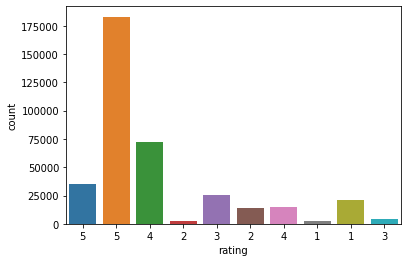

In [16]:
sns.countplot(x = edadata.rating);

**sentiment**
We can see that even with rating = 1,2,3 combined as "Negative", we still have an imbalanced target variable. This confirm my initial feeling that review data tends to be very imbalanced. We will need to take this into account when building our models.

<AxesSubplot:xlabel='sentiment', ylabel='count'>

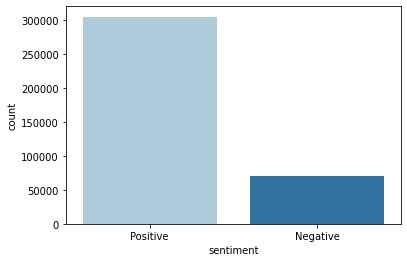

In [18]:
sns.countplot(x = edadata.sentiment, palette = "Paired")

In [19]:
edadata.sentiment.value_counts(normalize = True)

Positive    0.813679
Negative    0.186321
Name: sentiment, dtype: float64

#### 4.2.2 Distribution of characters and words in a review
It seems that negative reviews have more characters than positive reviews (makes sense!).

In [25]:
pos_review = edadata[edadata.sentiment == 'Positive']
neg_review = edadata[edadata.sentiment == 'Negative']
print(f"Average character length of positive reviews is {round(pos_review.review.str.len().mean())}")
print(f"Average character length of negative reviews is {round(neg_review.review.str.len().mean())}")

Average character length of positive reviews is 386
Average character length of negative reviews is 526


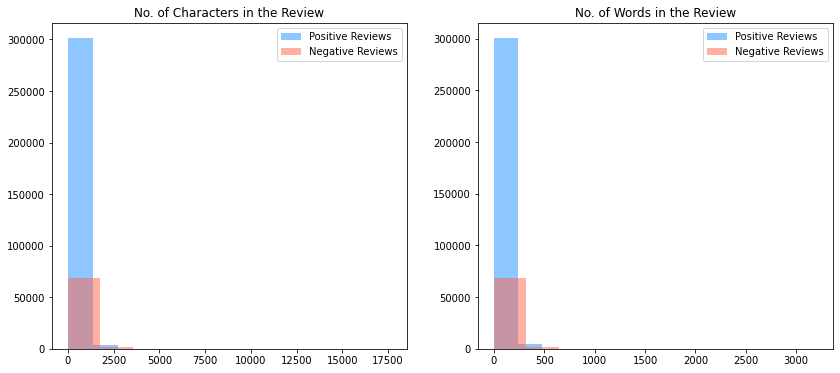

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# characters
pos_char_len = pos_review['review'].str.len()
neg_char_len = neg_review['review'].str.len()
ax1.hist(pos_char_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax1.hist(neg_char_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax1.legend()
ax1.title.set_text("No. of Characters in the Review")

# words
pos_word_len = pos_review['review'].str.split().apply(lambda x: len(x))
neg_word_len = neg_review['review'].str.split().apply(lambda x: len(x))
ax2.hist(pos_word_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax2.hist(neg_word_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax2.legend()
ax2.title.set_text("No. of Words in the Review")

We can see some clear outliers here.

In [29]:
edadata['char_len'] = edadata['review'].str.len()
edadata['word_len'] = edadata['review'].str.split().apply(lambda x: len(x))
edadata.describe()

,char_len,word_len
count,374718.000000,374718.000000
mean,412.140746,74.274094
std,329.411701,60.804825
min,9.000000,2.000000
25%,203.000000,36.000000
50%,317.000000,57.000000
75%,509.000000,92.000000
max,17650.000000,3207.000000


In [32]:
edadata[edadata['char_len'] > 2000].head()

,review_id,rating,review,sentiment,char_len,word_len
165948,review_289957995,5,Thank you for the excellent food & wonderful e...,Positive,2544,448
40209,review_135602863,2,I probably won´t go back I had read all review...,Negative,2228,419
146751,review_460776310,4,Twice in one trip I loved this restaurant for ...,Positive,3042,551
1729,review_636943895,5,Best meal ever! So my friends and I went to Ba...,Positive,2084,411
6732,review_179116768,5,Best meal ever! Both my wife and I thought thi...,Positive,2623,482


In [44]:
edadata.loc[6732,:].review

"Best meal ever! Both my wife and I thought this was the best meals we both had ever. We are both from Toronto and I don't think there is a restaurant there than can top this one. This probably tops the restaurants we have visited in barcelona so far and tops the vacation so far. We had a 730pm reservation on a Sunday. I reserved the restaurant based upon the reviews on trip advisor. They were expecting us and actually knew our names as we entered the restaurant. The dining is intimate, dimly lit, and small which adds a romantic feel. The restaurant was almost empty when we entered but filled up quickly as the night progressed. The service at the restaurant was excellent, taking the time to explain the dishes and the wines. The staff were always nearby which makes the small restaurant feel work.  We both had the surprise tasting menu. I had the wine pairing and my wife did not. Each table that chose the surprise menu had slightly different courses. This is what we had. They were willin

In [45]:
edadata[edadata['char_len'] > 10000].head()

,review_id,rating,review,sentiment,char_len,word_len
106961,review_352140203,1,"The Curse of the two Michelin Stars So, to put...",Negative,17650,3207
182510,review_586241840,5,RESTAURANT REINVENTED ENIGMA Concept RESTAURA...,Positive,10159,1546
128388,review_231212570,5,Great fun restaurant Photos on blog. Opening R...,Positive,13717,2373
154776,review_240142343,4,Great food at ABaC PHOTOS & FULL REVIEW Abbeys...,Positive,10940,1864
407831,review_585205861,5,CAELIS...as in GASTRONOMIC HEAVENS ! CAELIS RE...,Positive,13477,2145


In [46]:
edadata.loc[407831,:].review

'CAELIS...as in GASTRONOMIC HEAVENS ! CAELIS RESTAURANT  CAELIS... as in gastronomic HEAVENS!  CARTAS DE AMOR PARA BARCELONA  Chapter 1  Love Letters to Barcelona  Love letters to the land of my grand parents... This is my "kind of review"; the one that I joyfully, dearly love to write.... A review about enjoying a new experience in a great gastronomic place... A place were palate pleasing and artistry abounds.  This are “my kind" of review lines. The ones that-in my own style- flows from my mind-when my heart and soul are touched by true-gastronomic recipes, artistically worked and served with style on plates and, beyond that; served, as well, on a nice, tasteful ambiance... like it was here at "Caelis”.  Before involving myself in this Review notes: I’m obliged to NOTE that “Caelis”, named by his well known and praised chef Romain Fornell (originally from Toulouse) is holding 1 Michelin ⭐️ Star. In my humble opinion, after been in many-many starred restaurants not only in Spain, but 

Although these are genuine reviews, but they are also very lengthy and would make our text representation quite high dimensional. So we will truncate these very long reviews and remove them from our data set.

In [51]:
ninetypercentile = edadata.char_len.quantile(0.90)
ninetypercentile

776.0

In [52]:
edadata_trim = edadata.copy()
edadata_trim = edadata[edadata.char_len <= ninetypercentile]
edadata_trim.describe()

,char_len,word_len
count,337276.000000,337276.000000
mean,330.145937,59.152946
std,166.095334,30.956594
min,9.000000,2.000000
25%,193.000000,34.000000
50%,291.000000,52.000000
75%,436.000000,79.000000
max,776.000000,167.000000


In [54]:
pos_review = edadata_trim[edadata_trim.sentiment == 'Positive']
neg_review = edadata_trim[edadata_trim.sentiment == 'Negative']
print(f"Average character length of positive reviews is {round(pos_review.review.str.len().mean())}")
print(f"Average character length of negative reviews is {round(neg_review.review.str.len().mean())}")

Average character length of positive reviews is 322
Average character length of negative reviews is 368


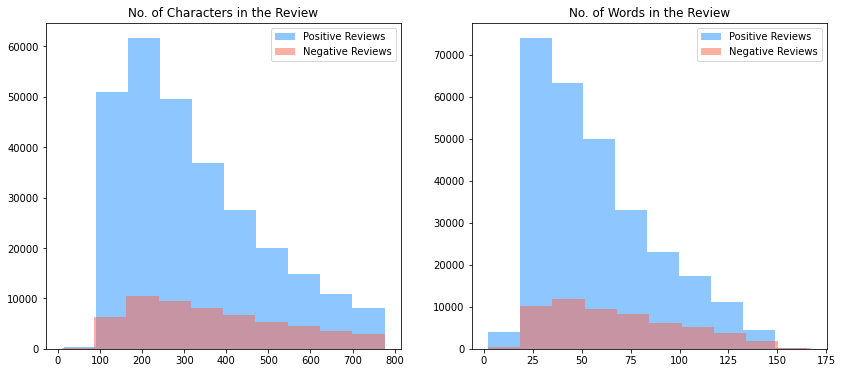

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# characters
pos_char_len = pos_review['review'].str.len()
neg_char_len = neg_review['review'].str.len()
ax1.hist(pos_char_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax1.hist(neg_char_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax1.legend()
ax1.title.set_text("No. of Characters in the Review")

# words
pos_word_len = pos_review['review'].str.split().apply(lambda x: len(x))
neg_word_len = neg_review['review'].str.split().apply(lambda x: len(x))
ax2.hist(pos_word_len, alpha = 0.5, label = 'Positive Reviews', color = 'dodgerblue')
ax2.hist(neg_word_len, alpha = 0.5, label = 'Negative Reviews', color = 'tomato')
ax2.legend()
ax2.title.set_text("No. of Words in the Review")

We can see that positive reviews and negative reviews generally follow the same shape.

#### 4.2.3 Word Cloud of Positive vs. Negative Reviews

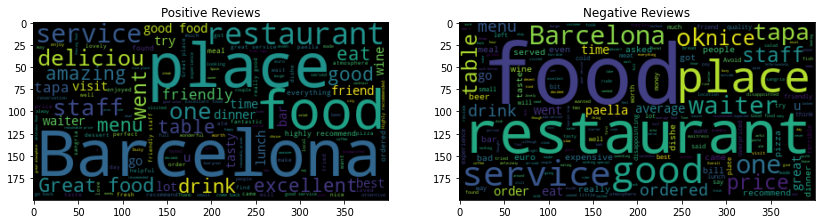

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# disaster word cloud
txt = " ".join([twt for twt in pos_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.title.set_text("Positive Reviews")

# non disaster word cloud
txt = " ".join([twt for twt in neg_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Negative Reviews");

#### 4.2.4 N-gram Analysis

In [57]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

stop_words = set(stopwords.words("english"))

In [59]:
# Unigrams
pos_unigrams = defaultdict(int)
neg_unigrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev):
        pos_unigrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev):
        neg_unigrams[word] += 1
        
df_pos_unigrams = pd.DataFrame(sorted(pos_unigrams.items(), key=lambda x: x[1])[::-1])
df_neg_unigrams = pd.DataFrame(sorted(neg_unigrams.items(), key=lambda x: x[1])[::-1])

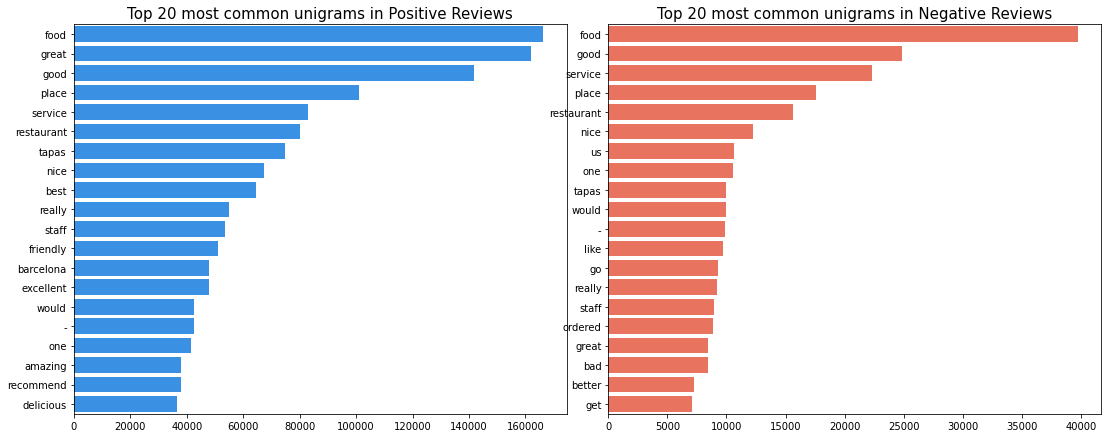

In [73]:
N = 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.tight_layout()

sns.barplot(y=df_pos_unigrams[0].values[:N], x=df_pos_unigrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_unigrams[0].values[:N], x=df_neg_unigrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common unigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Reviews', fontsize=15);

We see that the unigrams are very similar, and this is to be expected, because both the positive and negative reviews are about the same restaurants and the same products. What's more important is the context in which these words are used, so let's have a look at trigrams or even Ngrams = 5.

In [62]:
# Trigrams
pos_trigrams = defaultdict(int)
neg_trigrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev, n_gram = 3):
        pos_trigrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev, n_gram = 3):
        neg_trigrams[word] += 1
        
df_pos_trigrams = pd.DataFrame(sorted(pos_trigrams.items(), key=lambda x: x[1])[::-1])
df_neg_trigrams = pd.DataFrame(sorted(neg_trigrams.items(), key=lambda x: x[1])[::-1])

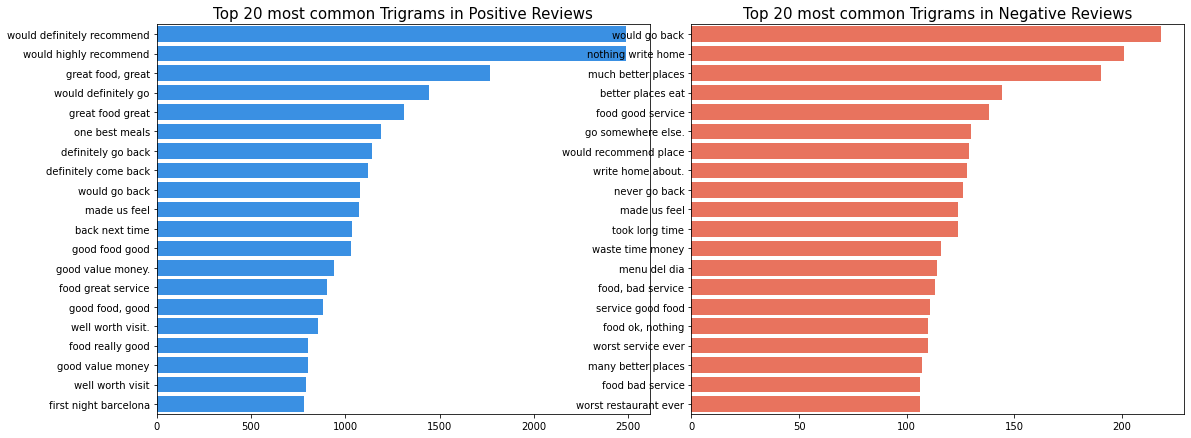

In [72]:
N = 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.tight_layout()

sns.barplot(y=df_pos_trigrams[0].values[:N], x=df_pos_trigrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_trigrams[0].values[:N], x=df_neg_trigrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common Trigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common Trigrams in Negative Reviews', fontsize=15);

We can now see a lot of differences between positive and negative reviews after adding more context through more consecutive (3) words.

In [64]:
# Pentagrams
pos_pentagrams = defaultdict(int)
neg_pentagrams = defaultdict(int)

for rev in pos_review.review:
    for word in generate_ngrams(rev, n_gram = 5):
        pos_pentagrams[word] += 1
        
for rev in neg_review.review:
    for word in generate_ngrams(rev, n_gram = 5):
        neg_pentagrams[word] += 1
        
df_pos_pentagrams = pd.DataFrame(sorted(pos_pentagrams.items(), key=lambda x: x[1])[::-1])
df_neg_pentagrams = pd.DataFrame(sorted(neg_pentagrams.items(), key=lambda x: x[1])[::-1])

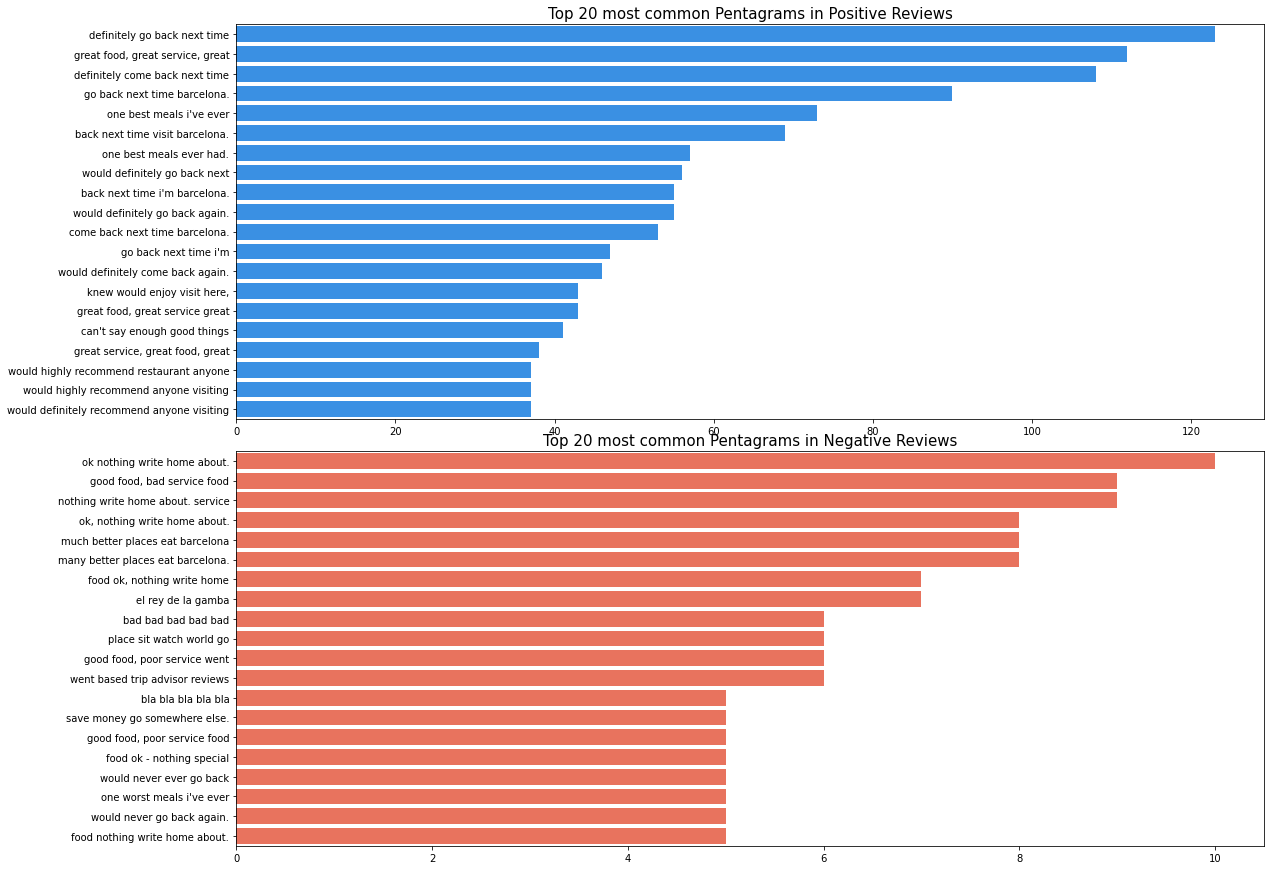

In [74]:
N = 20

fig, axes = plt.subplots(nrows=2, figsize=(15, 12))
plt.tight_layout()

sns.barplot(y=df_pos_pentagrams[0].values[:N], x=df_pos_pentagrams[1].values[:N], ax=axes[0], color='dodgerblue', alpha = 1)
sns.barplot(y=df_neg_pentagrams[0].values[:N], x=df_neg_pentagrams[1].values[:N], ax=axes[1], color = 'tomato', alpha = 1)

axes[0].set_title(f'Top {N} most common Pentagrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common Pentagrams in Negative Reviews', fontsize=15);

We can now see even more differences between positive and negative reviews after adding more context through more consecutive (5) words.

### 4.3 Summary of EDA Results
#### Data Quality Exploration:
- No missing values
- No duplicate values to be dropped
- The "rating" feature has inconsistent data entries, however, since it is very imbalanced, we will not use the "rating" feature at all, and instead we will rely on "sentiment" as our target. We can drop the "rating" column altogether.
#### Data Characteristic Exploration:
- "sentiment" is not as imbalanced as "rating"， however it is still relatively imbalanced, and **requires attention during modelling process**
- there are some very long reviews that can be considered outliers, and we have decided to only include up to the 90th percentile of data in terms of character length. In otherwords we are only keeping reviews less than or equal to 776 characters in length.
- based on N-gram analysis, we can see that the negative and positive reviews are indeed talking about different topics.




In [ ]:
### redo the X, y for trainval, since we have less data now

In [86]:
edadata.drop(['rating','char_len','word_len'], axis = 1, inplace = True)
edadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374718 entries, 150327 to 386348
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  374718 non-null  object
 1   review     374718 non-null  object
 2   sentiment  374718 non-null  object
dtypes: object(3)
memory usage: 19.5+ MB


In [87]:
edadata.head()

,review_id,review,sentiment
150327,review_646954484,The best sushi in Barcelona! What a treat! Fre...,Positive
43614,review_735484397,Fantastic !! Food at this place is simply awes...,Positive
113861,review_163709852,Worth the wait! Everyone that has been to Bo d...,Positive
331406,review_127320404,Come and eat here! The hot and sour soup was t...,Positive
143261,review_150510792,Amazing LLamber Finally an amazing & high qual...,Positive


------------

## 5. Data Preparation and Cleaning
Customer review data is typically quite dirty and must be cleaned before feeding into our models. For example, reviews tend to contain a lot of punctuations, emojis and stopwords, these often don't add additional meanings to the text but cause confusion for the algorithms.

There are many steps in preparing text data, the first step is often text cleaning, where we remove text components that are noisy and not useful for our model, such as punctuations,and stop words. The next step is often word tokenization, where we turn raw text into numerical representations that can be understood and analyzed by computers.

### 5.1 Text Cleaning
We will apply the most commonly used cleaning steps here. Note that we will not use word stemming or lemmatizations here, because we will be using word embedding models, and stemmed/lemmatized words may interfere with the performance of these models.

In [83]:
def text_clean(text):
  # Removing urls
  url = re.compile(r'https?://\S+|www\.\S+')
  text = url.sub(r'',text)

  # Removing html tags
  html = re.compile(r'<.*?>')
  text = html.sub(r'',text)

  # Removing emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Removing punctuations and converting to lower case
  table= str.maketrans('','',string.punctuation)
  text = text.translate(table)

  text= str(text)
  training_tokens = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
    
  # removing stop words
  stop_words = stopwords.words('english')
  stop_words.append('barcelona')
  stop_words = set(stop_words)
  tokens_nostopwords = [word for word in training_tokens if not word in stop_words]
     
  # joining words into a sentence
  text_nostopwords = ' '.join(tokens_nostopwords)
        
  # removing numbers
  text_nonumbers = ''.join(word for word in text_nostopwords if word.isdigit()==0)
  
  return text_nonumbers

In [88]:
clean_review = edadata.copy()
clean_review['review'] = clean_review.review.apply(lambda x: text_clean(x))

In [89]:
edadata.review.head()

150327    The best sushi in Barcelona! What a treat! Fre...
43614     Fantastic !! Food at this place is simply awes...
113861    Worth the wait! Everyone that has been to Bo d...
331406    Come and eat here! The hot and sour soup was t...
143261    Amazing LLamber Finally an amazing & high qual...
Name: review, dtype: object

In [90]:
clean_review.review.head()

150327    best sushi treat freshly made sushi great roll...
43614     fantastic food place simply awesome made reser...
113861    worth wait everyone bo de b tell long wait tru...
331406    come eat hot sour soup best ive since leaving ...
143261    amazing llamber finally amazing high quality d...
Name: review, dtype: object

As we can see the cleaned review data are free to punctuations, stopwords and common emojis.

**All Reviews**

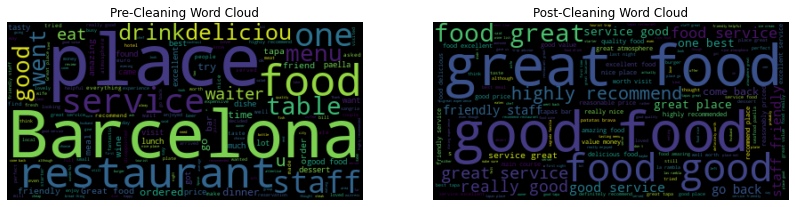

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join([word for word in edadata.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join([word for word in clean_review.review]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

**Positive Reviews**

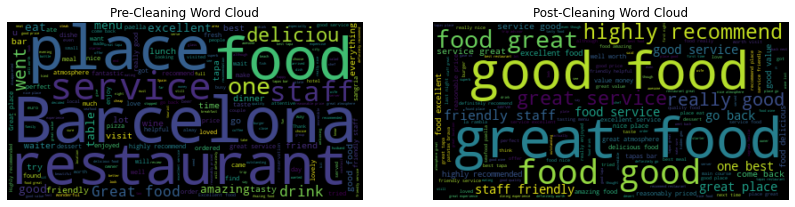

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join(set([word for word in pos_review.review])) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join(set([word for word in clean_review[clean_review.sentiment == "Positive"].review])) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

**Negative Reviews**

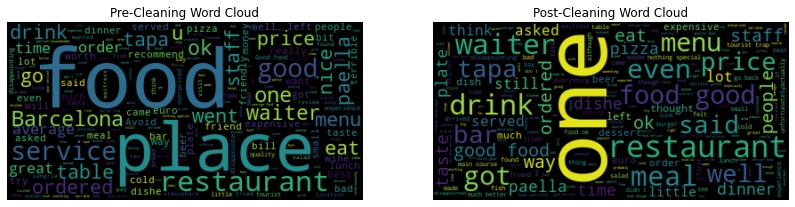

In [97]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join(set([review for review in neg_review.review])) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join(set([rev for rev in clean_review[clean_review.sentiment == "Negative"].review])) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

We can very clearly see that our cleaned data make much more sense compared with uncleaned raw data.

### 5.2 GloVe Representation